In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

tf.config.experimental.enable_op_determinism()
print("TF Version:", tf.__version__)


TF Version: 2.19.0


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = np.stack([x_train]*3, axis=-1).astype("float32") / 255.0
x_test  = np.stack([x_test]*3, axis=-1).astype("float32") / 255.0

print("Original:", x_train.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Original: (60000, 28, 28, 3)


In [ ]:
def resize32(x):
    return tf.image.resize(x, [32,32]).numpy()

x_train = resize32(x_train)
x_test  = resize32(x_test)

print("Resized:", x_train.shape)


Resized: (60000, 32, 32, 3)


In [ ]:
# Downscale to 16×16
x_train_small = tf.image.resize(x_train, [16,16], method="bicubic")
x_test_small  = tf.image.resize(x_test,  [16,16], method="bicubic")

# Upscale back to 32×32
x_train_lr = resize32(x_train_small)
x_test_lr  = resize32(x_test_small)

print("LR→HR:", x_train_lr.shape)


LR→HR: (60000, 32, 32, 3)


In [ ]:
def create_triplets(x_hr, x_lr, labels, num_triplets=120_000):
    """
    Mirrors quadruplet sampler style but for triplets:
    (anchor_hr, positive_lr, negative_hr)
    """
    label_to_indices = {lbl: np.where(labels == lbl)[0] for lbl in range(10)}
    triplets = set()
    rng = np.random.default_rng(SEED)

    while len(triplets) < num_triplets:
        # Choose class
        c = rng.choice(10)

        # Anchor HR
        a_idx = rng.choice(label_to_indices[c])

        # Positive LR
        p_idx = rng.choice(label_to_indices[c])

        # Negative class
        neg_class = rng.choice([x for x in range(10) if x != c])
        n_idx = rng.choice(label_to_indices[neg_class])

        triplets.add((a_idx, p_idx, n_idx))

    anchors, positives, negatives = [], [], []
    for a, p, n in triplets:
        anchors.append(x_hr[a])
        positives.append(x_lr[p])  # LR version used as positive
        negatives.append(x_hr[n])

    return (
        np.array(anchors, dtype=np.float32),
        np.array(positives, dtype=np.float32),
        np.array(negatives, dtype=np.float32)
    )


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import regularizers

def build_embedding(input_shape=(32,32,3), embedding_dim=128, weight_decay=1e-4):

    base = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )

    inp = layers.Input(input_shape)
    x = inp * 255.0
    x = preprocess_input(x)
    x = base(x)
    x = layers.Dropout(0.15)(x)
    x = layers.Dense(
        embedding_dim,
        kernel_regularizer=regularizers.l2(weight_decay)
    )(x)
    x = layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=1))(x)

    return Model(inp, x, name="EmbeddingModel")

embedding_model = build_embedding()
embedding_model.summary()


/tmp/ipython-input-886293208.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "EmbeddingModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,421,952 (9.24 MB)

 Trainable params: 2,387,840 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, 3, axis=1)

        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss


In [ ]:
def build_triplet_model(embedding):
    inp_a = layers.Input((32,32,3))
    inp_p = layers.Input((32,32,3))
    inp_n = layers.Input((32,32,3))

    emb_a = embedding(inp_a)
    emb_p = embedding(inp_p)
    emb_n = embedding(inp_n)

    out = layers.concatenate([emb_a, emb_p, emb_n], axis=1)
    return Model([inp_a, inp_p, inp_n], out)

triplet_model = build_triplet_model(embedding_model)

triplet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=triplet_loss(margin=1.0)
)

triplet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingModel      │ (None, 128)       │  2,421,952 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ EmbeddingModel[0… │
│ (Concatenate)       │                   │            │ EmbeddingModel[1… │
│                     │                   │            │ EmbeddingModel[2… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,421,952 (9.24 MB)

 Trainable params: 2,387,840 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
anchors, positives, negatives = create_triplets(
    x_hr=x_train,
    x_lr=x_train_lr,
    labels=y_train,
    num_triplets=120_000
)

N = len(anchors)
val_size = int(0.2 * N)

rng = np.random.default_rng(SEED)
idx = rng.permutation(N)

train_idx = idx[val_size:]
val_idx   = idx[:val_size]

a_tr, p_tr, n_tr = anchors[train_idx], positives[train_idx], negatives[train_idx]
a_val, p_val, n_val = anchors[val_idx], positives[val_idx], negatives[val_idx]

print("Train:", len(train_idx), "Validation:", len(val_idx))

Train: 96000 Validation: 24000


In [ ]:
BATCH = 64

train_ds = tf.data.Dataset.from_tensor_slices(
    ((a_tr, p_tr, n_tr), np.zeros(len(a_tr), dtype=np.float32))
).batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    ((a_val, p_val, n_val), np.zeros(len(a_val), dtype=np.float32))
).batch(BATCH).prefetch(tf.data.AUTOTUNE)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = triplet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 221s 115ms/step - loss: 0.4773 - val_loss: 0.2008
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 168s 112ms/step - loss: 0.1366 - val_loss: 0.1442
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 168s 112ms/step - loss: 0.0940 - val_loss: 0.1288
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 168s 112ms/step - loss: 0.0752 - val_loss: 0.1307
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 168s 112ms/step - loss: 0.0628 - val_loss: 0.1246
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 167s 111ms/step - loss: 0.0517 - val_loss: 0.1068
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 165s 110ms/step - loss: 0.0444 - val_loss: 0.1086
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 165s 110ms/step - loss: 0.0405 - val_loss: 0.1156
Epoch 9/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 167s 111ms/step - loss: 0.0352 - val_loss: 0.0936
Epoch 10/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 168s 112ms/step - loss: 0.0303 - val_loss: 0.1165
Epoch 11/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 165s 110ms/step - loss: 0

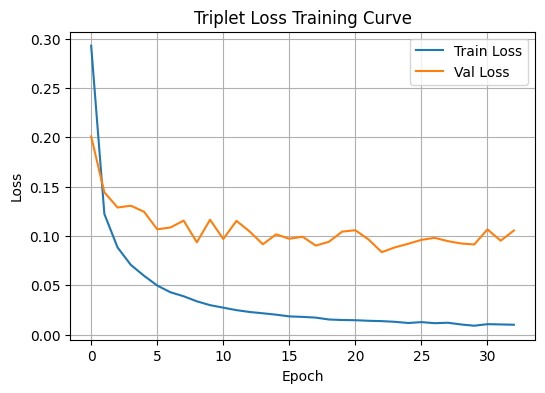

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Triplet Loss Training Curve")
plt.grid()
plt.show()


In [ ]:
x_train_comb = np.concatenate([x_train, x_train_lr], axis=0)
y_train_comb = np.concatenate([y_train, y_train], axis=0)

x_test_comb = np.concatenate([x_test, x_test_lr], axis=0)
y_test_comb = np.concatenate([y_test, y_test], axis=0)

train_emb = embedding_model.predict(x_train_comb, batch_size=256)
test_emb  = embedding_model.predict(x_test_comb, batch_size=256)


469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Accuracy: 0.87545
Macro F1: 0.8745517546627226
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      2000
           1       0.98      0.98      0.98      2000
           2       0.79      0.81      0.80      2000
           3       0.88      0.88      0.88      2000
           4       0.76      0.79      0.78      2000
           5       0.97      0.97      0.97      2000
           6       0.70      0.61      0.65      2000
           7       0.92      0.96      0.94      2000
           8       0.98      0.98      0.98      2000
           9       0.97      0.94      0.95      2000

    accuracy                           0.88     20000
   macro avg       0.87      0.88      0.87     20000
weighted avg       0.87      0.88      0.87     20000



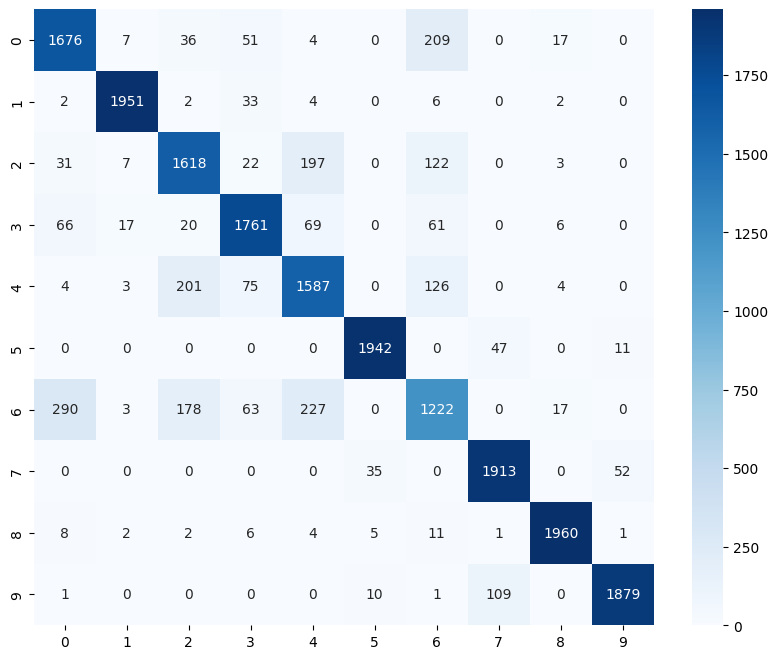

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_emb, y_train_comb)

y_pred = knn.predict(test_emb)

print("Accuracy:", accuracy_score(y_test_comb, y_pred))
print("Macro F1:", f1_score(y_test_comb, y_pred, average="macro"))
print(classification_report(y_test_comb, y_pred))

cm = confusion_matrix(y_test_comb, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()


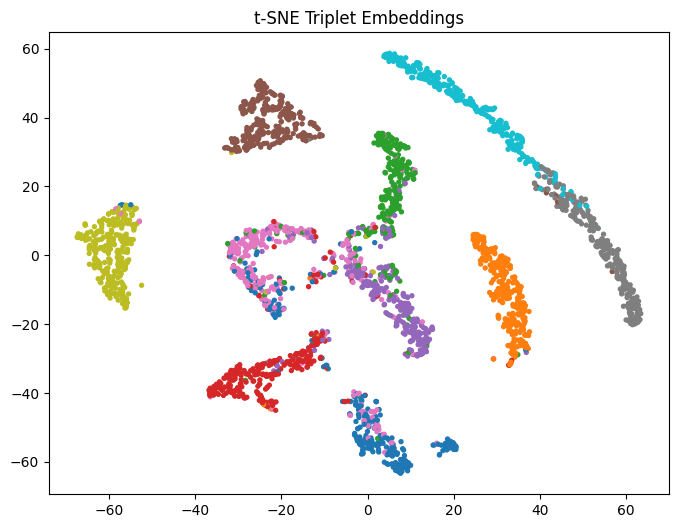

In [ ]:
subset = 3000
idx = np.random.RandomState(SEED).choice(len(test_emb), subset, replace=False)

emb2d = TSNE(n_components=2, random_state=SEED, init="random").fit_transform(test_emb[idx])
y_sub = y_test_comb[idx]

plt.figure(figsize=(8,6))
plt.scatter(emb2d[:,0], emb2d[:,1], c=y_sub, cmap='tab10', s=8)
plt.title("t-SNE Triplet Embeddings")
plt.show()
